# Pipeline Model for PDF Extraction

## Step 0: Installing dependencies

Please follow the `README.md` file in the project root folder for installing the dependencies. 

## Step 1: Downloading models

Please download the used models from this [link](https://drive.google.com/drive/folders/1smHqME-Qjks6-RqKUgP-A7Pz8wH6D_BX?usp=sharing) to the `models` folder in this directory:

- Mask R-CNN models trained on the publaynet dataset for identifying blocks of text from image inputs. Please save as `models/publaynet/mask_rcnn_R_50_FPN_3x`.

- Faster R-CNN models trained on the publaynet dataset for identifying euqation blocks from image inputs. Please save as `models/MFD/fast_rcnn_R_50_FPN_3x`.

- LayoutLM models trained on a modified DocBank dataset for classifying block categories. Please save as `models/docbank-classifier/layoutlm-v2/checkpoint-8000/`. 


## Step 2: Model Initialization 

In [1]:
import sys
import os 

import layoutparser as lp
from tqdm import tqdm

sys.path.append("../src")
from scienceparseplus.pdftools import * 
from scienceparseplus.modeling.layoutlm import *
from scienceparseplus.modeling.pipeline import *

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [2]:
block_predictorA = ObjectDetectionBlockPredictor(
     config_path ='models/publaynet/mask_rcnn_R_50_FPN_3x/config.yaml',
     model_path  ='models/publaynet/mask_rcnn_R_50_FPN_3x/model_final.pth',
     extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.6, 
                   "MODEL.ROI_HEADS.NMS_THRESH_TEST", 0.2],
     label_map   ={0: "text", 1: "title", 2: "list", 3:"table", 4:"figure"}
    
) # pre-trained on publaynet

block_predictorB = ObjectDetectionBlockPredictor(
     config_path ='models/MFD/fast_rcnn_R_50_FPN_3x/config.yaml',
     model_path  ='models/MFD/fast_rcnn_R_50_FPN_3x/model_final.pth',
     extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.6, 
                   "MODEL.ROI_HEADS.NMS_THRESH_TEST", 0.2],
     label_map   ={1: "equation"}
) # For detecting equations, pre-trained on the MFD Dataset 


layoutlm_label_map = {
    "paragraph": 0, "title": 1, "equation": 2,
    "reference": 3, "section": 4, "list": 5,
    "table": 6, "caption": 7, "author": 8,
    "abstract": 9, "footer": 10, "date": 11, 
}

block_classifier = LayoutLMBlockPredictor(
    model_path = "models/docbank-classifier/layoutlm-v2/checkpoint-8000/",
    tokenizer_path = "microsoft/layoutlm-base-uncased",
    label_map={idx: name for name, idx in layoutlm_label_map.items()}
) # For block text classification, pre-trained on 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [3]:
pdf_extractor = PDFExtractor('PDFPlumber')
# We use PDFPlumber for extracting tokens from PDFs 

## Step 3: Load PDF Documents and Start Parsing 

### PDF parsing and data format

In [4]:
# Extracting both tokens and screenshots from PDF files 
pdf_filename = '0a238252712f2c7f887d32056d36a26fcefaa634.pdf'

pdf_layouts, page_images = pdf_extractor.extract(pdf_filename, resize_image=True)

In [5]:
pdf_layouts[0].keys()
# pdf_layouts is a list of dictionaries, which store the 
# page index, width, height, and tokens for each page 
# in the PDF document 

dict_keys(['index', 'width', 'height', 'tokens'])

In [6]:
pdf_layouts[0]['tokens'][0]
# Each token is stored as the lp.Textblock dataclass 

TextBlock(block=Rectangle(x_1=59.776, y_1=40.718, x_2=103.621, y_2=49.685), text=Biostatistics, id=0, type=None, parent=None, next=None, score=None, style=1)

### PDF Structure Extraction - Visual-based models 

In [7]:
page_index = 1 # page 1 has a equation region 
pdf_layout = pdf_layouts[page_index]
page_image = page_images[page_index]

tokens = pdf_layout['tokens']

general_layouts = block_predictorA.detect(page_image, tokens)
# Detects the block structures in the input page_image 

/Users/shannons/miniconda3/envs/layoutparser/lib/python3.6/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


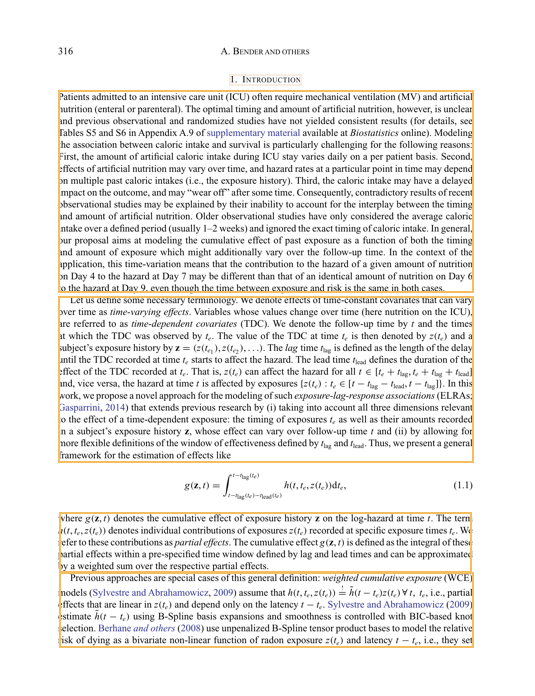

In [8]:
lp.draw_box(page_image.copy(), general_layouts.get_all_blocks_regions())
# Show all detected blocks from the models. 
# The publaynet model could not identify the equation region 

In [9]:
equation_layouts = block_predictorB.detect(page_image, general_layouts.remaining_tokens)
# Identify the equation region 

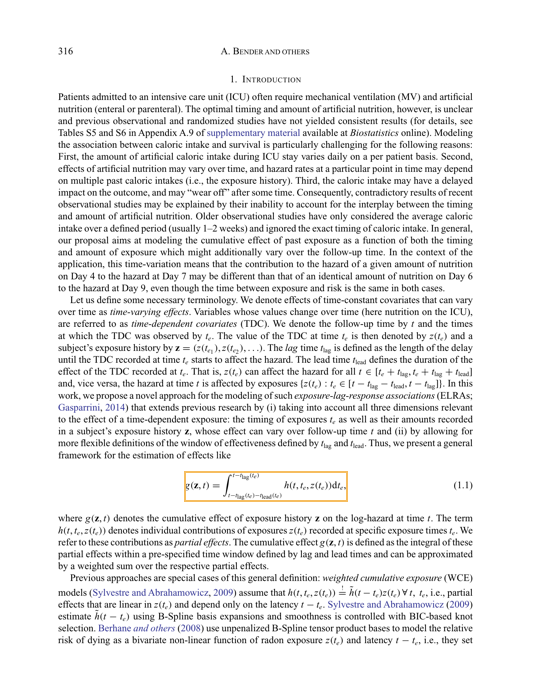

In [10]:
lp.draw_box(page_image.copy(), equation_layouts.get_all_blocks_regions())
# It successfully identifies the equation region

In [11]:
merged_layouts = HierarchicalLayout(
    bundles=general_layouts.bundles + equation_layouts.bundles,
    remaining_tokens=equation_layouts.remaining_tokens
)
# Merge the results from the two models 

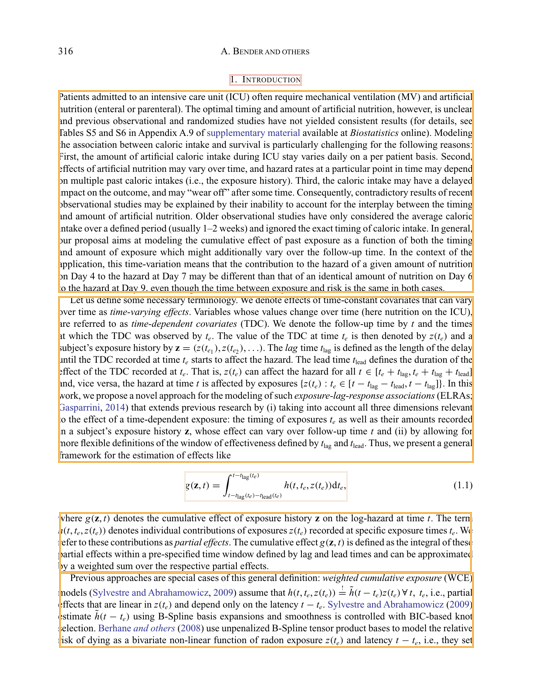

In [12]:
lp.draw_box(page_image.copy(), merged_layouts.get_all_blocks_regions())
# Check if they are successfully merged 

### PDF Structure Extraction - Text-based models 

For all blocks with textual categories, we further use the LayoutLM model to the identify refined categories of the blocks.

In [13]:
TEXTUAL_BLOCKS = ['text', 'title', 'list']

for bundle in merged_layouts.bundles: 
    if bundle.block.type not in TEXTUAL_BLOCKS: 
        continue 

    width, height = pdf_layout['width'], pdf_layout['height']
    detected_tokens = block_classifier.detect(bundle.tokens, width, height) 
    # Identify the category of the block based on tokens, and assign the
    # tokens in the block with the predicted category 
    
    bundle.block.type = detected_tokens[0].type 
    bundle.tokens = detected_tokens

In [14]:
merged_layouts.to_dataframe().head(10)
# Check the output of 

,id,x_1,y_1,x_2,y_2,text,category,parent,confidence,is_block
0,0,58.112247,90.935364,473.582245,292.881073,Patients admitted to an intensive care unit (I...,paragraph,-1.0,0.998911,True
1,1,58.984371,296.523285,473.810425,462.747284,Let us deﬁne some necessary terminology. We de...,paragraph,-1.0,0.998644,True
2,2,59.019634,572.665039,473.888550,647.492004,Previous approaches are special cases of this ...,paragraph,-1.0,0.996128,True
3,3,59.543442,512.721130,471.115479,572.414917,"where g ( z , t ) denotes the cumulative effec...",paragraph,-1.0,0.994450,True
4,4,229.568619,74.633812,301.572021,85.439034,1. I NTRODUCTION,section,-1.0,0.780815,True
5,5,184.584427,471.481689,347.600983,501.951569,"t − t lag ( t e ) g ( z , t ) = h ( t , t , z ...",equation,-1.0,0.995135,True
6,8,58.281000,92.573000,89.684000,102.535000,Patients,paragraph,0.0,5.672181,False
7,9,92.094000,92.573000,126.964000,102.535000,admitted,paragraph,0.0,5.672181,False
8,10,129.375000,92.573000,137.125000,102.535000,to,paragraph,0.0,5.672181,False
9,11,139.536000,92.573000,148.941000,102.535000,an,paragraph,0.0,5.672181,False


There are 10 columns in this table, namely:

    id, x_1, y_1, x_2, y_2, text, category, parent, confidence, and is_block.

The DataFrame is composed of two parts:
1. the first several rows are all the "block"s in this layout,
    which are generated from `self.get_all_blocks_regions`.
2. the other rows are for the tokens, and generated based on
    `self.get_all_tokens`.

The `is_block` feature in the table will be used for discriminating between
block rows and token rows.

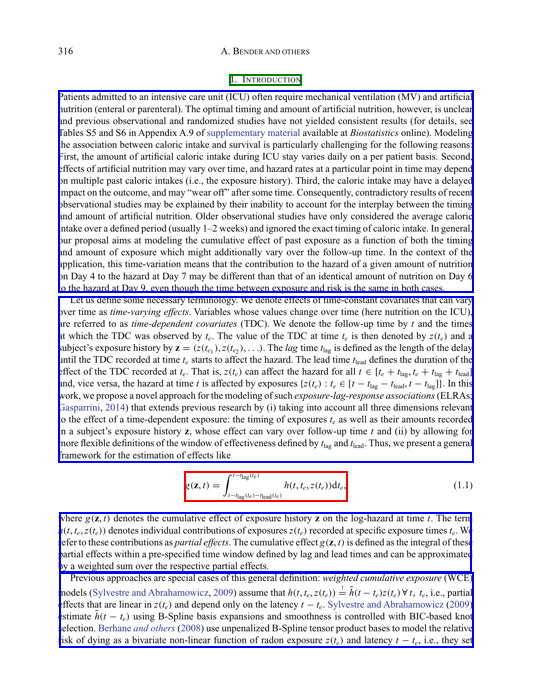

In [15]:
lp.draw_box(page_image.copy(), merged_layouts.get_all_blocks_regions(), 
            color_map={"paragraph":'blue', "section":"green", "equation":"red"})
# It correctly identifies the block categoreis 

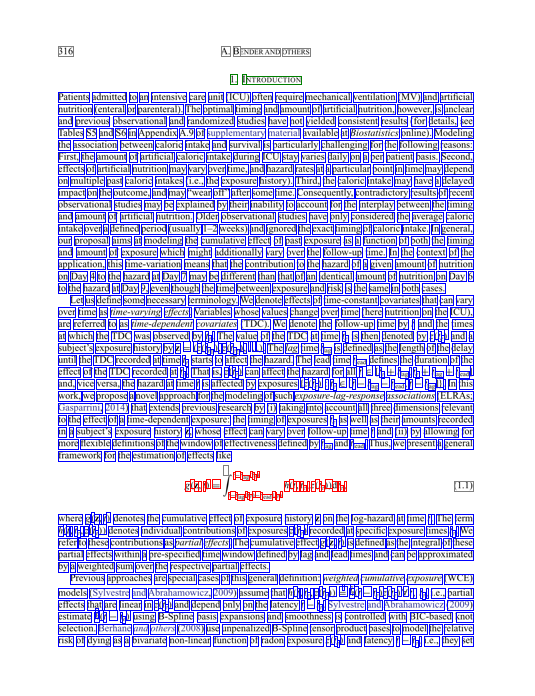

In [16]:
lp.draw_box(page_image.copy(), 
            merged_layouts.get_all_tokens(inherit_block_class=True), 
            box_width=1,
            color_map={"paragraph":'blue', "section":"green", 
                       "equation":"red", None: "grey"})

# check all the token categories 
# Note, there are some tokens without being included in any blocks,
# And they do not have any class labels. 

### Combine Together 

In [17]:
def layout_extractor(page_image, tokens, textual_blcoks=['text', 'title', 'list']):
    
    # Detecting Blocks from images 
    general_layouts = block_predictorA.detect(page_image, pdf_layout['tokens'])
    equation_layouts = block_predictorB.detect(page_image, general_layouts.remaining_tokens)
    
    merged_layouts = HierarchicalLayout(
        bundles=general_layouts.bundles + equation_layouts.bundles,
        remaining_tokens=equation_layouts.remaining_tokens
    )
    
    # Predicting block text categories
    for bundle in merged_layouts.bundles: 
        if bundle.block.type not in textual_blcoks: 
            continue 

        width, height = pdf_layout['width'], pdf_layout['height']
        detected_tokens = block_classifier.detect(bundle.tokens, width, height) 

        bundle.block.type = detected_tokens[0].type 
        bundle.tokens = detected_tokens
    
    return merged_layouts

In [19]:
base_save_path = os.path.join('export', os.path.splitext(pdf_filename)[0])

viz_color_map = {
    None: "#C0C0C0",
    "abstract": "#ffb6c1",
    "author": "#02028b",
    "caption": "#00ff03",
    "date": "#0f0000",
    "equation": "#ff0000",
    "figure": "#ff01ff",
    "footer": "#ffffff",
    "list": "#302070",
    "paragraph": "#b0c4de",
    "reference": "#309000",
    "section": "#0603ff",
    "table": "#01ffff",
    "title": "#00bfff",
}

for pdf_layout, page_image in tqdm(zip(pdf_layouts, page_images), total=len(pdf_layouts)):
    
    
    page_index = pdf_layout['index']
    
    cur_save_path = f'{base_save_path}/{page_index}'
    os.makedirs(cur_save_path, exist_ok=True)
    
    detected_layouts = layout_extractor(page_image, pdf_layout)
    
    detected_layouts.to_dataframe().to_csv(f'{cur_save_path}/layout.csv', index=None)
    
    lp.draw_box(page_image.copy(), detected_layouts.get_all_blocks_regions(), 
            color_map=viz_color_map).save(f'{cur_save_path}/block_layout.jpg')
    
    lp.draw_box(page_image.copy(), 
            detected_layouts.get_all_tokens(inherit_block_class=True), 
            box_width=1,
            color_map=viz_color_map).save(f'{cur_save_path}/token_layout.jpg')

100%|██████████| 17/17 [03:10<00:00, 11.21s/it]
